In [1]:
## My model
import QKLSTM
import QLSTM
import FWP
import Model
import QAOA
from Model import LSTM, FWPWrapper, ModelTrain

## basis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## random
import random
import math
from typing import List, Callable, Tuple
## ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import minimize
## QML
import pennylane as qml
from pennylane import qaoa
import networkx as nx
## access file
import os

torch.manual_seed(42)
np.random.seed(42)
qml.math.random.seed(42)
random.seed(42)

In [2]:
import importlib
import QKLSTM 
importlib.reload(QKLSTM)
import QLSTM 
importlib.reload(QLSTM)
import Model 
importlib.reload(Model)

<module 'Model' from '/beegfs/home/yuchao/QKLSTM-VQE/QK-QAOA/Model.py'>

## Define Model

In [3]:
"""
Define model and train
"""
# --- Model Training ---
def build_and_train_model(model_type, mapping_type, layers, input_feature_dim,
                          max_total_params, loss_function_type, qaoa_layers,
                          lr_lstm, lr_mapping, epochs, steps_recurrent_loop_train,
                          conv_tol_lstm, Model_save_path, train_set, val_set,
                          time_out, continue_train=False, load_path=None):

    if model_type in ["LSTM", "QK", "VQC"]:
        model = LSTM(model_type=model_type,
                     mapping_type=mapping_type,
                     layers=layers,
                     input_feature_dim=input_feature_dim,
                     max_total_params=max_total_params,
                     loss_function_type=loss_function_type)
    elif model_type == "FWP":
        model = FWPWrapper(mapping_type=mapping_type,
                           input_feature_dim=input_feature_dim,
                           max_total_params=max_total_params,
                           loss_function_type=loss_function_type,
                           layers=layers)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    trainer = ModelTrain(model=model,
                         qaoa_layers=qaoa_layers,
                         lr_lstm=lr_lstm,
                         lr_mapping=lr_mapping,
                         num_rnn_iteration=steps_recurrent_loop_train)

    print(f"\n--- Training {model_type} Model ---")
    trainer.train(train_data=train_set,
                  val_data=val_set,
                  epochs=epochs,
                  conv_tol_lstm=conv_tol_lstm,
                  time_out=time_out)

    torch.save(model.state_dict(), f"{Model_save_path}_{model_type}_{loss_function_type}.pth")
    print("Model saved successfully!")

    return model, trainer



## Train Data

the size of training set is 1008


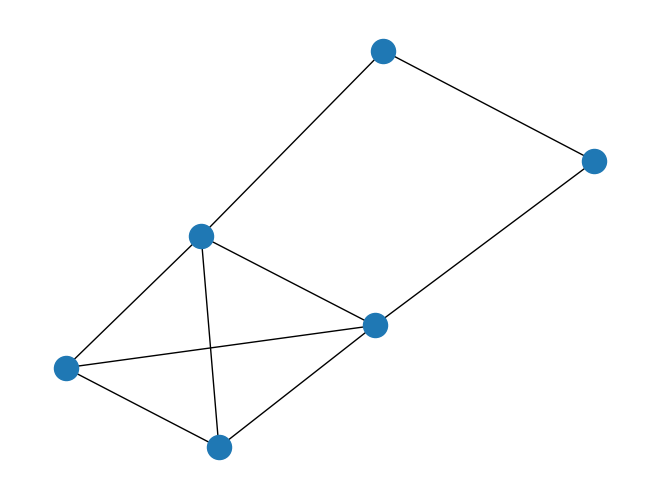

In [4]:
train_set = []
for i in range(6,10): #4
    for j in range(3,9):#6
        for _ in range(42):
            random_graph = nx.gnp_random_graph(n = i, p=j/i, seed = 42)
            train_set.append(random_graph)
nx.draw(train_set[0])
print(f"the size of training set is {len(train_set)}")

the size of training set is 5


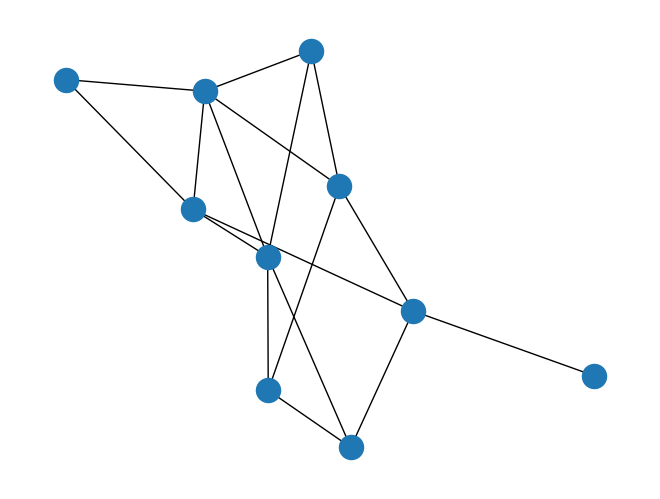

In [5]:
val_set = []

for j in range(3,8):#6
    random_graph = nx.gnp_random_graph(n = 10, p=j/10, seed = 42)
    val_set.append(random_graph)
nx.draw(val_set[0])
print(f"the size of training set is {len(val_set)}")

## Define model and Train

In [6]:
layers = 1 #LSTM
mapping_type = "ID"
input_feature_dim = 4#layer*qaoa_layers*2
max_total_params = 4    
loss_function_type = "weighted" # observed improvement or weighted
qaoa_layers = 2
epochs = 50 #1000
steps_recurrent_loop_train = 10
steps_recurrent_loop_test = 10
conv_tol_lstm = 1e-3
Results_save_path = "model_result_RMSprop"
Model_save_path = "model_params_RMSprop"
time_out = 8*60*60

lr_qaoa = 0.001
max_iter_qaoa = 300
conv_tol_qaoa = 1e-6
qaoa_optimizer = "SGD"

### LSTM

In [ ]:
lstm_model, lstm_trainer = build_and_train_model(
    model_type = "LSTM",
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 1e-4, #1e-4
    lr_mapping = 0.01,
    epochs = epochs, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set= val_set,
    time_out = time_out,
    continue_train= False,
    load_path = None
    )

--- Model Summary ---
LSTM(
  (lstm): LSTM(5, 4, batch_first=True)
  (mapping): Identity()
)
  LSTM Parameters: 176
  Mapping Parameters: 0

--- Training LSTM Model ---

--- Starting LSTM Model Training ---
Epoch 1/50
 > Molecule 200/1008 - Loss: 1.99733341
 > Molecule 400/1008 - Loss: 2.80131197
 > Molecule 600/1008 - Loss: 2.99230337
 > Molecule 800/1008 - Loss: 2.95332599
 > Molecule 1000/1008 - Loss: 4.60408735
Epoch 1 Mean loss: 2.81956209, Mean val loss:7.24200119
Current learning rate: 0.0001000000
Epoch 2/50
 > Molecule 200/1008 - Loss: 1.70548427
 > Molecule 400/1008 - Loss: 2.54885125
 > Molecule 600/1008 - Loss: 2.91257286
 > Molecule 800/1008 - Loss: 2.90057182
 > Molecule 1000/1008 - Loss: 4.55378532
Epoch 2 Mean loss: 2.65894637, Mean val loss:7.19219698
Current learning rate: 0.0001000000
Epoch 3/50
 > Molecule 200/1008 - Loss: 1.68787956
 > Molecule 400/1008 - Loss: 2.52155852


In [5]:
lstm_model = Model.LSTM(model_type = "LSTM",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_LSTM_model.pth")
lstm_model.load_state_dict(state_dict)
lstm_trainer = Model.ModelTrain(model = lstm_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 1e-4,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

# FWP

In [ ]:
q_fwp_model, q_fwp_trainer = build_and_train_model(
    model_type = "FWP",         
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 5e-5,  #4e-5, #8e-5,
    lr_mapping = 0.01,
    epochs = epochs, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set = val_set,
    time_out = time_out,
    continue_train = False,
    load_path = None
)


--- Training FWP Model ---

--- Starting FWP Model Training ---
Epoch 1/50
 > Molecule 200/1008 - Loss: 1.97313571
 > Molecule 400/1008 - Loss: 2.57548761
 > Molecule 600/1008 - Loss: 2.84229517
 > Molecule 800/1008 - Loss: 2.78586793
 > Molecule 1000/1008 - Loss: 7.94400311
Epoch 1 Mean loss: 3.26823143, Mean val loss:8.30079365
Current learning rate: 0.0000500000
Epoch 2/50
 > Molecule 200/1008 - Loss: 1.85032308
 > Molecule 400/1008 - Loss: 2.50883889
 > Molecule 600/1008 - Loss: 2.82462955
 > Molecule 800/1008 - Loss: 2.89693403
 > Molecule 1000/1008 - Loss: 7.41222668
Epoch 2 Mean loss: 2.97924424, Mean val loss:9.56070293
Current learning rate: 0.0000500000
Epoch 3/50
 > Molecule 200/1008 - Loss: 1.71479416
 > Molecule 400/1008 - Loss: 2.42619467
 > Molecule 600/1008 - Loss: 2.80396605
 > Molecule 800/1008 - Loss: 2.89025760
 > Molecule 1000/1008 - Loss: 7.47244167
Epoch 3 Mean loss: 2.97319161, Mean val loss:7.90610403
Current learning rate: 0.0000500000
Epoch 4/50
 > Molecule 

In [ ]:
q_fwp_model = Model.LSTM(model_type = "FWP",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_FWP_model.pth")
q_fwp_model.load_state_dict(state_dict)
q_fwp_trainer = Model.ModelTrain(model = q_fwp_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 5e-5,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

# VQC

In [7]:
q_model, q_trainer = build_and_train_model(
    model_type = "VQC",
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 5e-5,#4e-5, #8e-5,
    lr_mapping = 0.01,
    epochs = epochs, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set= val_set,
    time_out = time_out,
    continue_train= False,
    load_path = None)

--- Model Summary ---
LSTM(
  (lstm): QLSTM(
    (clayer_in): Linear(in_features=10, out_features=4, bias=True)
    (clayer_out): Linear(in_features=4, out_features=5, bias=True)
  )
  (mapping): Identity()
)
  VQC Parameters: 69
  Mapping Parameters: 0

--- Training VQC Model ---

--- Starting VQC Model Training ---
Epoch 1/50
 > Molecule 200/1008 - Loss: 3.65545964
 > Molecule 400/1008 - Loss: 4.78041315
 > Molecule 600/1008 - Loss: 4.49159765
 > Molecule 800/1008 - Loss: 3.96845222
 > Molecule 1000/1008 - Loss: 5.74919367
Epoch 1 Mean loss: 4.22074006, Mean val loss:8.63437662
Current learning rate: 0.0000500000
Epoch 2/50
 > Molecule 200/1008 - Loss: 3.23454332
 > Molecule 400/1008 - Loss: 3.79160285
 > Molecule 600/1008 - Loss: 3.56295824
 > Molecule 800/1008 - Loss: 3.23020411
 > Molecule 1000/1008 - Loss: 3.97514415
Epoch 2 Mean loss: 3.35714123, Mean val loss:6.53544833
Current learning rate: 0.0000500000
Epoch 3/50
 > Molecule 200/1008 - Loss: 2.40070844
 > Molecule 400/1008 -

In [10]:
q_model = Model.LSTM(model_type = "VQC",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_VQC_model.pth")
q_model.load_state_dict(state_dict)
qk_trainer = Model.ModelTrain(model = q_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 5e-5,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

### QK

In [554]:
qk_model, qk_trainer = build_and_train_model(
    model_type = "QK",
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 5e-5,#4e-5, #8e-5,
    lr_mapping = 0.01,
    epochs = epochs, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set= val_set,
    time_out = time_out,
    continue_train= False,
    load_path = None)

--- Model Summary ---
LSTM(
  (lstm): QKLSTM(
    (clayer_in): Linear(in_features=10, out_features=4, bias=True)
    (clayer_out): Linear(in_features=4, out_features=5, bias=True)
  )
  (mapping): Identity()
)
  QK Parameters: 69
  Mapping Parameters: 0

--- Training QK Model ---

--- Starting QK Model Training ---
Epoch 1/50
 > Molecule 200/1008 - Loss: 4.36315536
 > Molecule 400/1008 - Loss: 5.61318684
 > Molecule 600/1008 - Loss: 5.27280712
 > Molecule 800/1008 - Loss: 4.60627699
 > Molecule 1000/1008 - Loss: 8.35375977
Epoch 1 Mean loss: 5.18883498, Mean val loss:10.93020471
Current learning rate: 0.0000500000
Epoch 2/50
 > Molecule 200/1008 - Loss: 3.48640561
 > Molecule 400/1008 - Loss: 4.42809963
 > Molecule 600/1008 - Loss: 4.10602903
 > Molecule 800/1008 - Loss: 3.54037166
 > Molecule 1000/1008 - Loss: 6.34539175
Epoch 2 Mean loss: 4.03465826, Mean val loss:8.54388689
Current learning rate: 0.0000500000
Epoch 3/50
 > Molecule 200/1008 - Loss: 2.30475187
 > Molecule 400/1008 - 

In [6]:
qk_model = Model.LSTM(model_type = "QK",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_good_QK_model.pth")
qk_model.load_state_dict(state_dict)
qk_trainer = Model.ModelTrain(model = qk_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 5e-5,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

## Evaluate

In [12]:
test_set = []

for i in range(10,13):
    for j in range(3,i):
        random_graph = nx.gnp_random_graph(n = i, p=j/i, seed = 42)
        test_set.append(random_graph)
        
#for j in range(3,8):#3~11
#    for i in range(2):
#        random_graph = nx.gnp_random_graph(n = 12, p=j/12, seed = 42)
#        test_set.append(random_graph)
print(len(test_set))

24


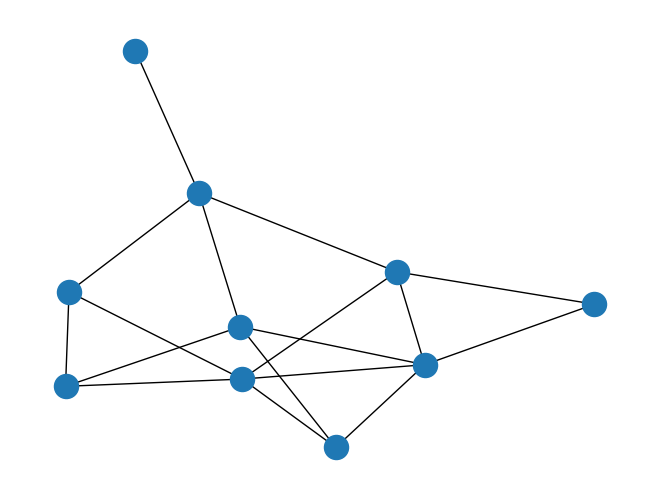

In [13]:
nx.draw(test_set[0])

In [ ]:
"""
Model Testing
"""
# --- Model Evaluating ---
print(f"\n--- Evaluating Model ---")

#params_rand = torch.rand(input_feature_dim, dtype = torch.float32)
params_rand = torch.tensor([0.01,0.01,0.01,0.01])

for i in range(len(test_set)):
    graph_test_result = {}
    
    # ----------------- LSTM -----------------
    lstm_predicted_params_list, lstm_predicted_energies_list = lstm_trainer.evaluate(
        graph_data=test_set[i],
        num_rnn_iteration=steps_recurrent_loop_test)

    print(f"{lstm_model.model_type} predicted energies:{lstm_predicted_energies_list}")
    print(f"{lstm_model.model_type} predicted params:{lstm_predicted_params_list[-1]}")

    # QAOA after LSTM
    print(f"\n--- QAOA optimization after LSTM ---")
    lstm_qaoa = QAOA.QAOA(graph=test_set[i], n_layers=qaoa_layers, with_meta=True)
    opt_lstm_qaoa = QAOA.QAOAptimizer(lstm_qaoa)
    conv_iter_lstm, final_params_lstm, final_energy_lstm, params_history_lstm, energy_history_lstm = opt_lstm_qaoa.run_optimization(
        initial_params=lstm_predicted_params_list[-1],
        optimizer=qaoa_optimizer,
        max_iter=max_iter_qaoa,
        learning_rate=lr_qaoa,
        conv_tol=conv_tol_qaoa
    )

    # ----------------- VQC -----------------
    vqc_predicted_params_list, vqc_predicted_energies_list = q_trainer.evaluate(
        graph_data=test_set[i],
        num_rnn_iteration=steps_recurrent_loop_test)

    print(f"{q_model.model_type} predicted energies:{vqc_predicted_energies_list}")
    print(f"{q_model.model_type} predicted params:{vqc_predicted_params_list[-1]}")

    # QAOA after VQC
    print(f"\n--- QAOA optimization after VQC ---")
    vqc_qaoa = QAOA.QAOA(graph=test_set[i], n_layers=qaoa_layers, with_meta=True)
    opt_vqc_qaoa = QAOA.QAOAptimizer(vqc_qaoa)
    conv_iter_vqc, final_params_vqc, final_energy_vqc, params_history_vqc, energy_history_vqc = opt_vqc_qaoa.run_optimization(
        initial_params=vqc_predicted_params_list[-1],
        optimizer=qaoa_optimizer,
        max_iter=max_iter_qaoa,
        learning_rate=lr_qaoa,
        conv_tol=conv_tol_qaoa
    )

    # ----------------- QK -----------------
    qk_predicted_params_list, qk_predicted_energies_list = qk_trainer.evaluate(
        graph_data=test_set[i],
        num_rnn_iteration=steps_recurrent_loop_test)

    print(f"{qk_model.model_type} predicted energies:{qk_predicted_energies_list}")
    print(f"{qk_model.model_type} predicted params:{qk_predicted_params_list[-1]}")

    # QAOA after QK
    print(f"\n--- QAOA optimization after QK ---")
    qk_qaoa = QAOA.QAOA(graph=test_set[i], n_layers=qaoa_layers, with_meta=True)
    opt_qk_qaoa = QAOA.QAOAptimizer(qk_qaoa)
    conv_iter_qk, final_params_qk, final_energy_qk, params_history_qk, energy_history_qk = opt_qk_qaoa.run_optimization(
        initial_params=qk_predicted_params_list[-1],
        optimizer=qaoa_optimizer,
        max_iter=max_iter_qaoa,
        learning_rate=lr_qaoa,
        conv_tol=conv_tol_qaoa
    )

    # ----------------- FWP -----------------
    fwp_predicted_params_list, fwp_predicted_energies_list = q_fwp_trainer.evaluate(
        graph_data=test_set[i],
        num_rnn_iteration=steps_recurrent_loop_test)

    print(f"{q_fwp_model.model_type} predicted energies:{fwp_predicted_energies_list}")
    print(f"{q_fwp_model.model_type} predicted params:{fwp_predicted_params_list[-1]}")

    # QAOA after FWP
    print(f"\n--- QAOA optimization after FWP ---")
    fwp_qaoa = QAOA.QAOA(graph=test_set[i], n_layers=qaoa_layers, with_meta=True)
    opt_fwp_qaoa = QAOA.QAOAptimizer(fwp_qaoa)
    conv_iter_fwp, final_params_fwp, final_energy_fwp, params_history_fwp, energy_history_fwp = opt_fwp_qaoa.run_optimization(
        initial_params=fwp_predicted_params_list[-1],
        optimizer=qaoa_optimizer,
        max_iter=max_iter_qaoa,
        learning_rate=lr_qaoa,
        conv_tol=conv_tol_qaoa
    )

    # ----------------- Random baseline -----------------
    print(f"\n--- Standard QAOA, random params ---")
    qaoa_test_rand = QAOA.QAOA(graph=test_set[i], n_layers=qaoa_layers, with_meta=False)
    opt_rand_qaoa = QAOA.QAOAptimizer(qaoa_test_rand)
    conv_iter_rand, final_params_rand, final_energy_rand, params_history_rand, energy_history_rand = opt_rand_qaoa.run_optimization(
        initial_params=params_rand,
        optimizer="SGD",
        max_iter=max_iter_qaoa,
        learning_rate=lr_qaoa,
        conv_tol=conv_tol_qaoa
    )

    # ----------------- Save Results -----------------
    graph_test_result = {
        'LSTM-QAOA': pd.Series(lstm_predicted_energies_list),
        'QAOA after LSTM': pd.Series(energy_history_lstm),
        'VQC-QAOA': pd.Series(vqc_predicted_energies_list),
        'QAOA after VQC': pd.Series(energy_history_vqc),
        'QK-QAOA': pd.Series(qk_predicted_energies_list),
        'QAOA after QK': pd.Series(energy_history_qk),
        'FWP-QAOA': pd.Series(fwp_predicted_energies_list),
        'QAOA after FWP': pd.Series(energy_history_fwp),
        'QAOA Random': pd.Series(energy_history_rand),
    }

    df_result = pd.DataFrame(graph_test_result)
    df_result.to_csv(f"{Results_save_path}_node_{len(test_set[i].nodes)}_{i}_edge_{len(test_set[i].edges)}_{i}.csv", index=False)
    print("\n--- Saving Complete ---")

    # ----------------- Plot -----------------
    print("Result of QAOA Optimization")
    plt.figure(figsize=(15,8))
    font = {'size':16}
    plt.rc('font', **font)

    plt.plot(range(1, len(lstm_predicted_energies_list)+1), lstm_predicted_energies_list, 
             label='LSTM-QAOA', color="darkblue", ls="dashed", markersize=9)
    plt.plot(range(1, len(energy_history_lstm)+1), energy_history_lstm, 
             label='QAOA after LSTM', color="darkblue", markersize=9)

    plt.plot(range(1, len(vqc_predicted_energies_list)+1), vqc_predicted_energies_list, 
             label='VQC-QAOA', ls="dashed", color="purple", markersize=9)
    plt.plot(range(1, len(energy_history_vqc)+1), energy_history_vqc, 
             label='QAOA after VQC', color="purple", markersize=9)

    plt.plot(range(1, len(qk_predicted_energies_list)+1), qk_predicted_energies_list, 
             label='QK-QAOA', ls="dashed", color="darkgreen", markersize=9)
    plt.plot(range(1, len(energy_history_qk)+1), energy_history_qk, 
             label='QAOA after QK', color="darkgreen", markersize=9)

    plt.plot(range(1, len(fwp_predicted_energies_list)+1), fwp_predicted_energies_list, 
             label='FWP-QAOA', ls="dashed", color="orange", markersize=9)
    plt.plot(range(1, len(energy_history_fwp)+1), energy_history_fwp, 
             label='QAOA after FWP', color="orange", markersize=9)

    plt.plot(range(1, len(energy_history_rand)+1), energy_history_rand, 
             label='QAOA, Random', color="darkred", markersize=9)

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"num_node={len(test_set[i].nodes)}, num_edge={len(test_set[i].edges)}")
    plt.legend()
    plt.show()

print("\n--- Simulation Complete ---")



--- Evaluating Model ---


NameError: name 'lstm_trainer' is not defined

## Traditional

In [576]:
import itertools

In [580]:
def cut_size(G, partition):
    cut = 0
    for u, v in G.edges():
        if partition[u] != partition[v]:  # edge crosses the cut
            cut += 1
    return cut

In [581]:
def brute_force_maxcut(G):
    n = G.number_of_nodes()
    nodes = list(G.nodes())
    best_cut = 0
    best_partition = None
    
    # Enumerate partitions (fix first node in set 0 to avoid symmetry)
    for bits in itertools.product([0,1], repeat=n-1):
        partition = {nodes[0]: 0}  # fix first node
        for i, bit in enumerate(bits, start=1):
            partition[nodes[i]] = bit
        
        c = cut_size(G, partition)
        if c > best_cut:
            best_cut = c
            best_partition = partition.copy()
    
    return best_cut, best_partition

In [588]:
for i in range(len(test_set)):
    best_cut, best_partition = brute_force_maxcut(test_set[i])
    print("Graph:        ",i)
    print("Best cut size:", best_cut)
    print("Best partition:", best_partition)

Graph:         0
Best cut size: 16
Best partition: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0}
Graph:         1
Best cut size: 16
Best partition: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 1, 11: 0}
Graph:         2
Best cut size: 18
Best partition: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1}
Graph:         3
Best cut size: 18
Best partition: {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1}
Graph:         4
Best cut size: 23
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1}
Graph:         5
Best cut size: 23
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 10: 1, 11: 1}
Graph:         6
Best cut size: 24
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1}
Graph:         7
Best cut size: 24
Best partition: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1,